In [1]:
import os
import matplotlib.pyplot as plt
from notebooks.visualization.activations_funcs import get_activation_dictionnary
from notebooks.visualization.random_networks_plots.plot_config import apply_plot_style
from notebooks.visualization.activations_funcs import get_all_connections
from paths import PROJECT_ROOT
plots_dir = os.path.join(PROJECT_ROOT, "plots")

NUM_PASSES = 3

apply_plot_style()

# Create plots directory if it doesn't exist
os.makedirs(plots_dir, exist_ok=True)

Changed working directory to /home/eudald/Escriptori/doctorat/connectome
Project root: /home/eudald/Escriptori/doctorat/connectome


In [3]:
from utils.helpers import load_neuron_coordinates

from joblib import Memory


cache_dir = os.path.join(PROJECT_ROOT, "notebooks", "visualization", "data", ".joblib_cache")
memory = Memory(location=cache_dir, verbose=0)


@memory.cache
def connections_cached():
    """Disk-cached version of get_all_connections()."""
    return get_all_connections()


@memory.cache
def activations_cached(num_passes: int = 4):
    """Disk-cached wrapper around get_activation_dictionnary()."""
    conn_dict = connections_cached()
    return get_activation_dictionnary(conn_dict, num_passes)

neuron_position_data = load_neuron_coordinates()

# Heavy cached computations
connections_dict = connections_cached()
activations_dict = activations_cached(NUM_PASSES)

# Panel A

/home/eudald/Escriptori/doctorat/connectome/notebooks/visualization/random_networks_plots/synapse_distributions.py:139: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


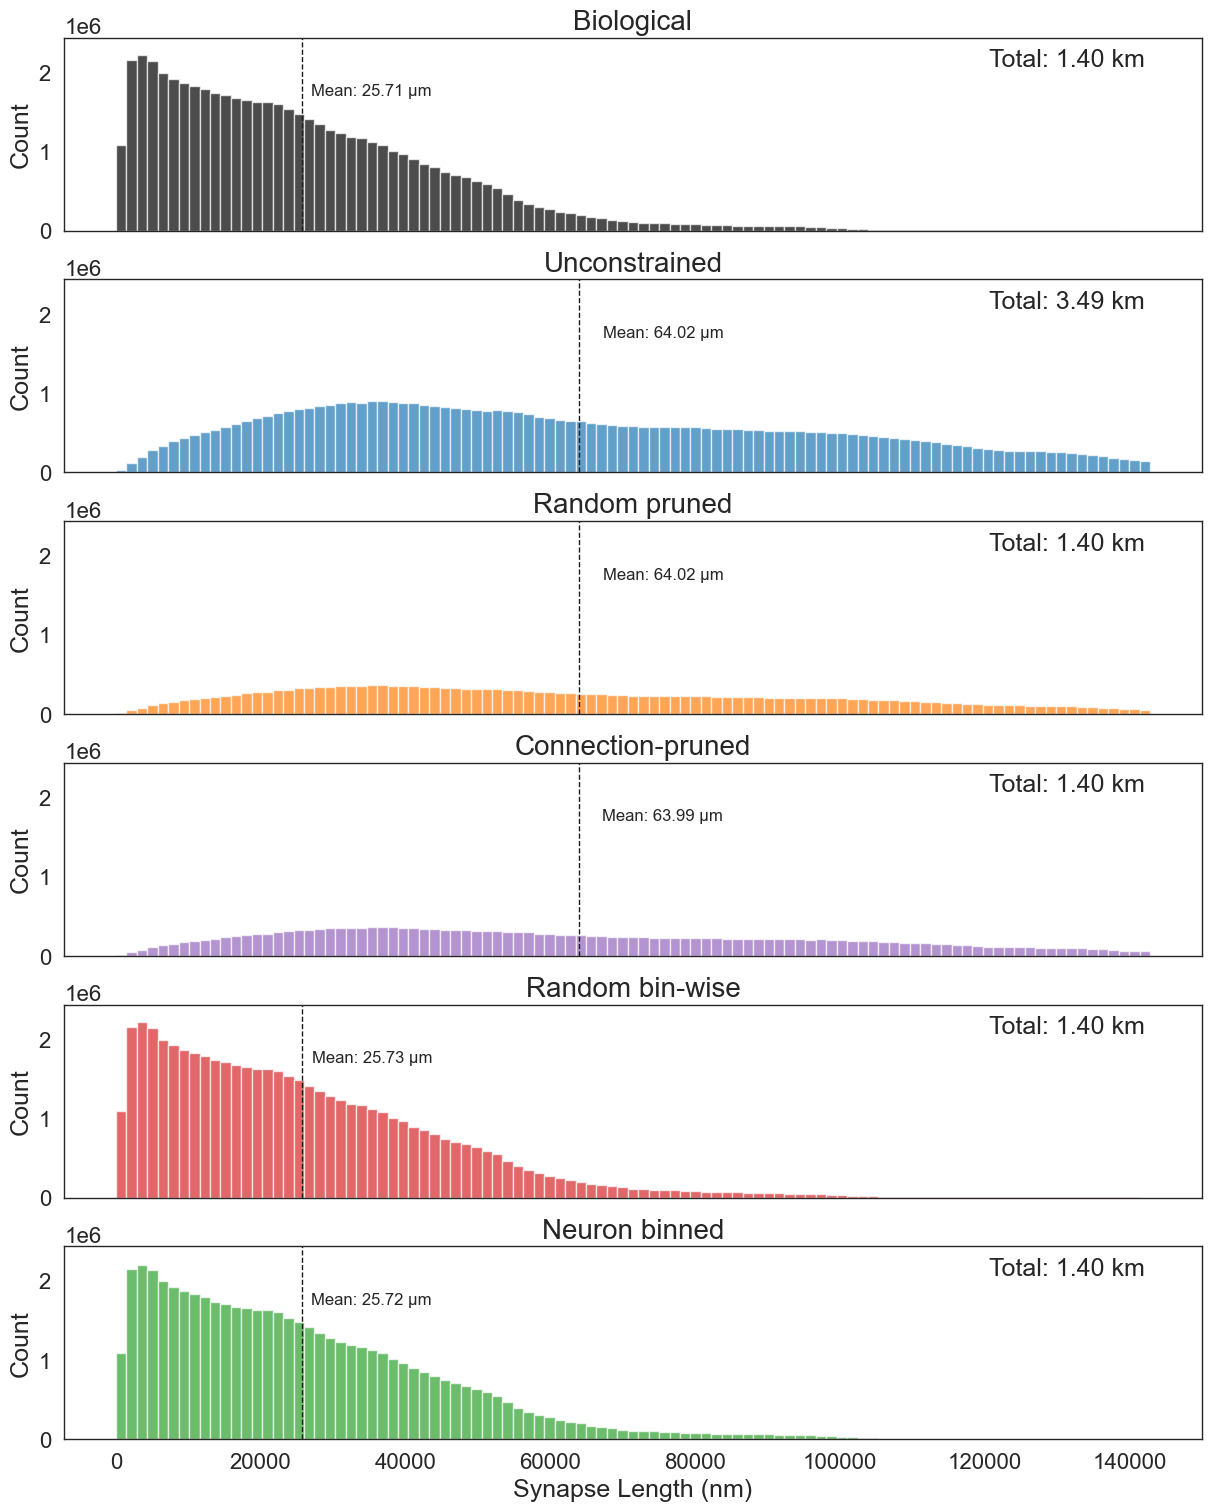

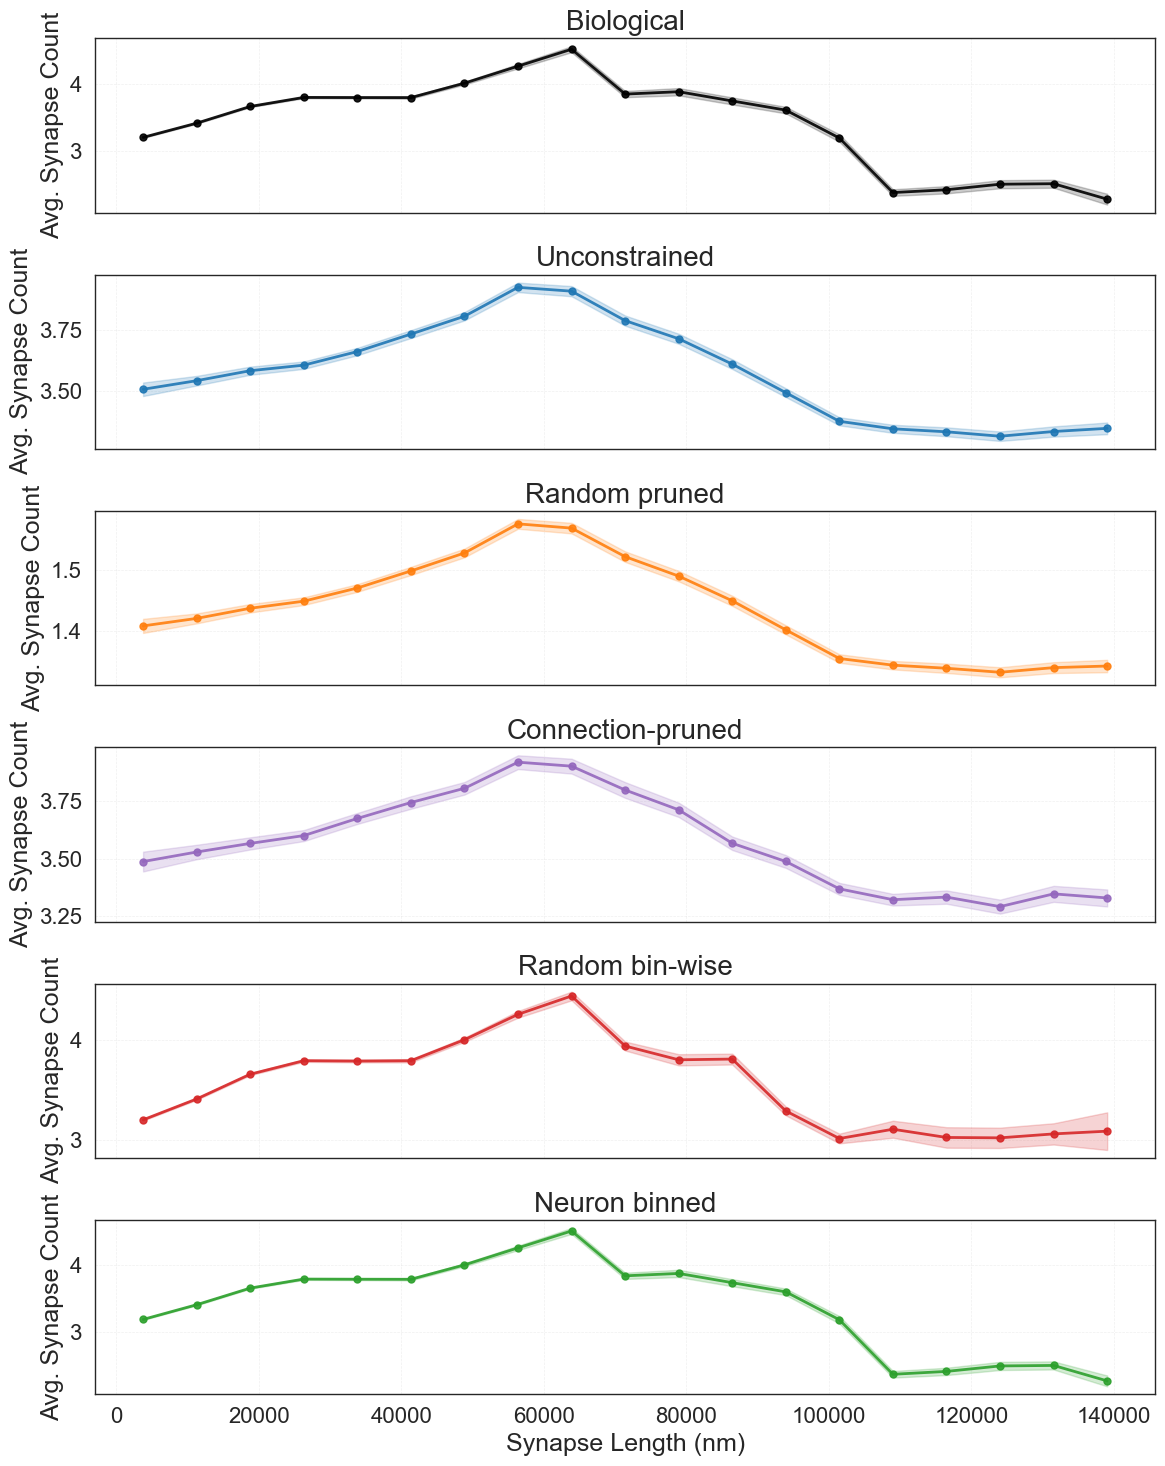

In [4]:
import importlib
from notebooks.visualization.random_networks_plots import activation_plots
importlib.reload(activation_plots)
from notebooks.visualization.random_networks_plots.synapse_distributions import plot_synapse_length_distributions

figa1, figa2 = plot_synapse_length_distributions(neuron_position_data, connections_dict, use_density=False, num_confidence_interval_se=2)

figa1.savefig(os.path.join(plots_dir, "synapse_length_distributions.png"),
            dpi=300, bbox_inches="tight", transparent=True)
figa1.savefig(os.path.join(plots_dir, "synapse_length_distributions.pdf"),
            bbox_inches="tight")

figa2.savefig(os.path.join(plots_dir, "synapse_count_per_length.png"),
            dpi=300, bbox_inches="tight", transparent=True)
figa2.savefig(os.path.join(plots_dir, "synapse_count_per_length.pdf"),
            bbox_inches="tight")


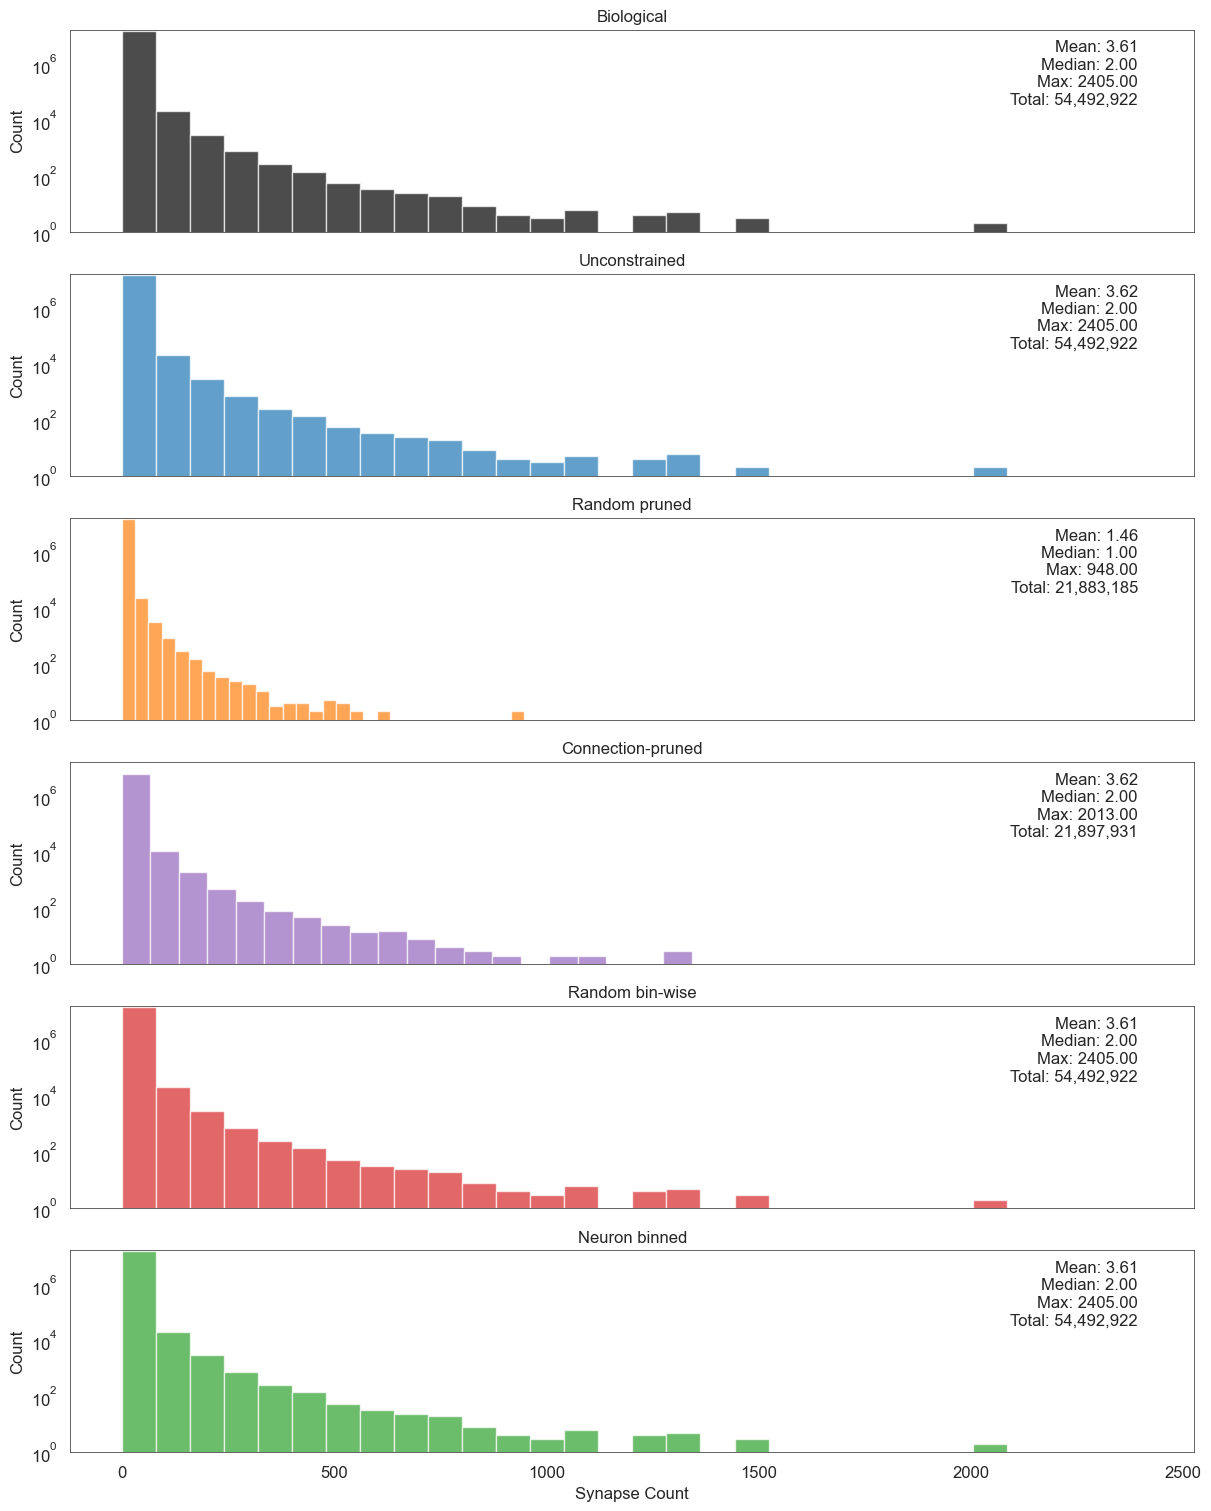

In [62]:
import importlib
from notebooks.visualization.random_networks_plots import synapse_distributions
importlib.reload(synapse_distributions)
from notebooks.visualization.random_networks_plots.synapse_distributions import plot_synapse_counts_histogram

fig = plot_synapse_counts_histogram(connections_dict, log_scale=True)
fig.savefig(os.path.join(plots_dir, "synapse_counts_histogram.png"),
            dpi=300, bbox_inches="tight", transparent=True)
fig.savefig(os.path.join(plots_dir, "synapse_counts_histogram.pdf"),
            bbox_inches="tight")

# Panel b

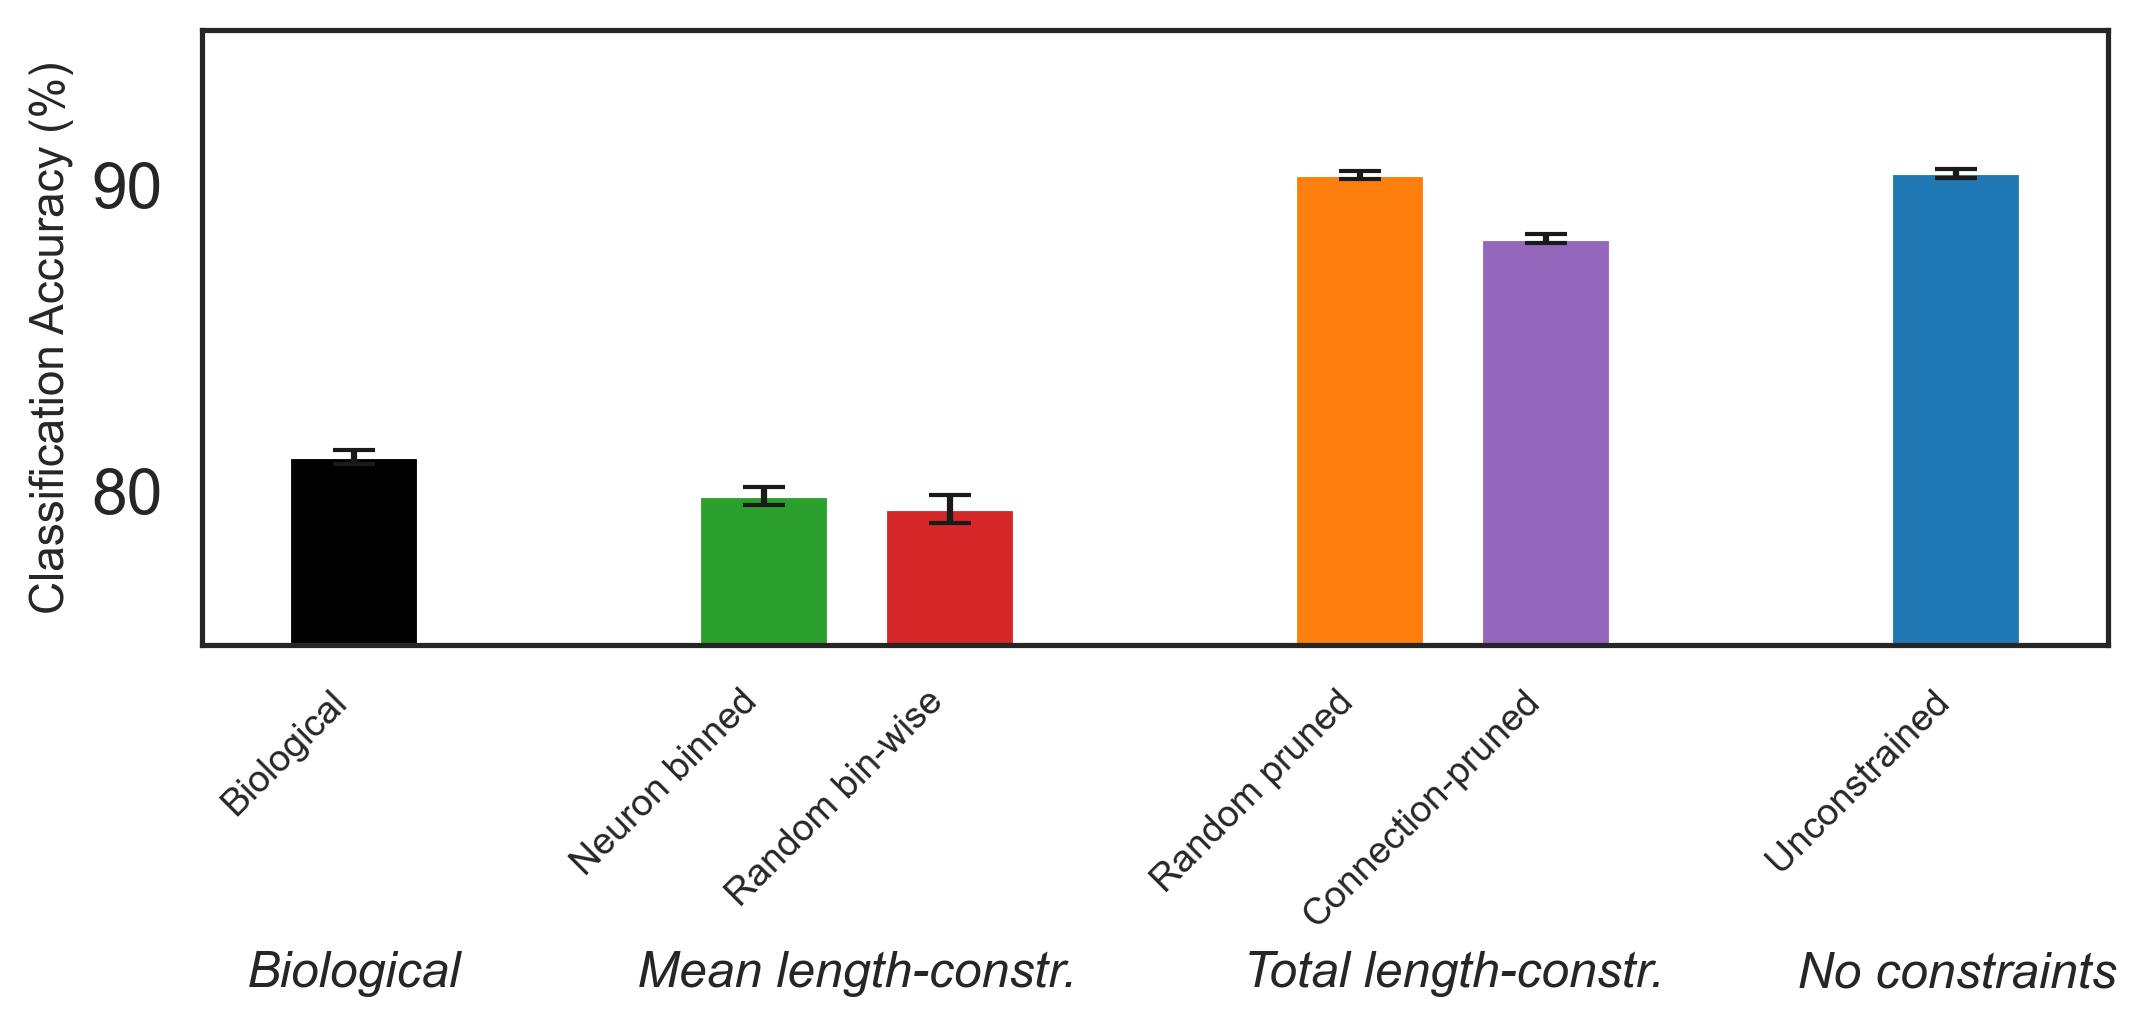

In [24]:
import pandas as pd
# reimport the module to avoid caching issues
import importlib
from notebooks.visualization.random_networks_plots import models_accuracy
importlib.reload(models_accuracy)

from notebooks.visualization.random_networks_plots.models_accuracy import grouped_accuracy_comparison_4groups

csv_path = "notebooks/visualization/data/randomizations_seeds.csv"
df = pd.read_csv(csv_path, dtype=str)

figb = grouped_accuracy_comparison_4groups(df)
plt.savefig(os.path.join(plots_dir,"efficiency_comparison.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir,"efficiency_comparison.pdf"), bbox_inches="tight") 
plt.show()

# Pancel c

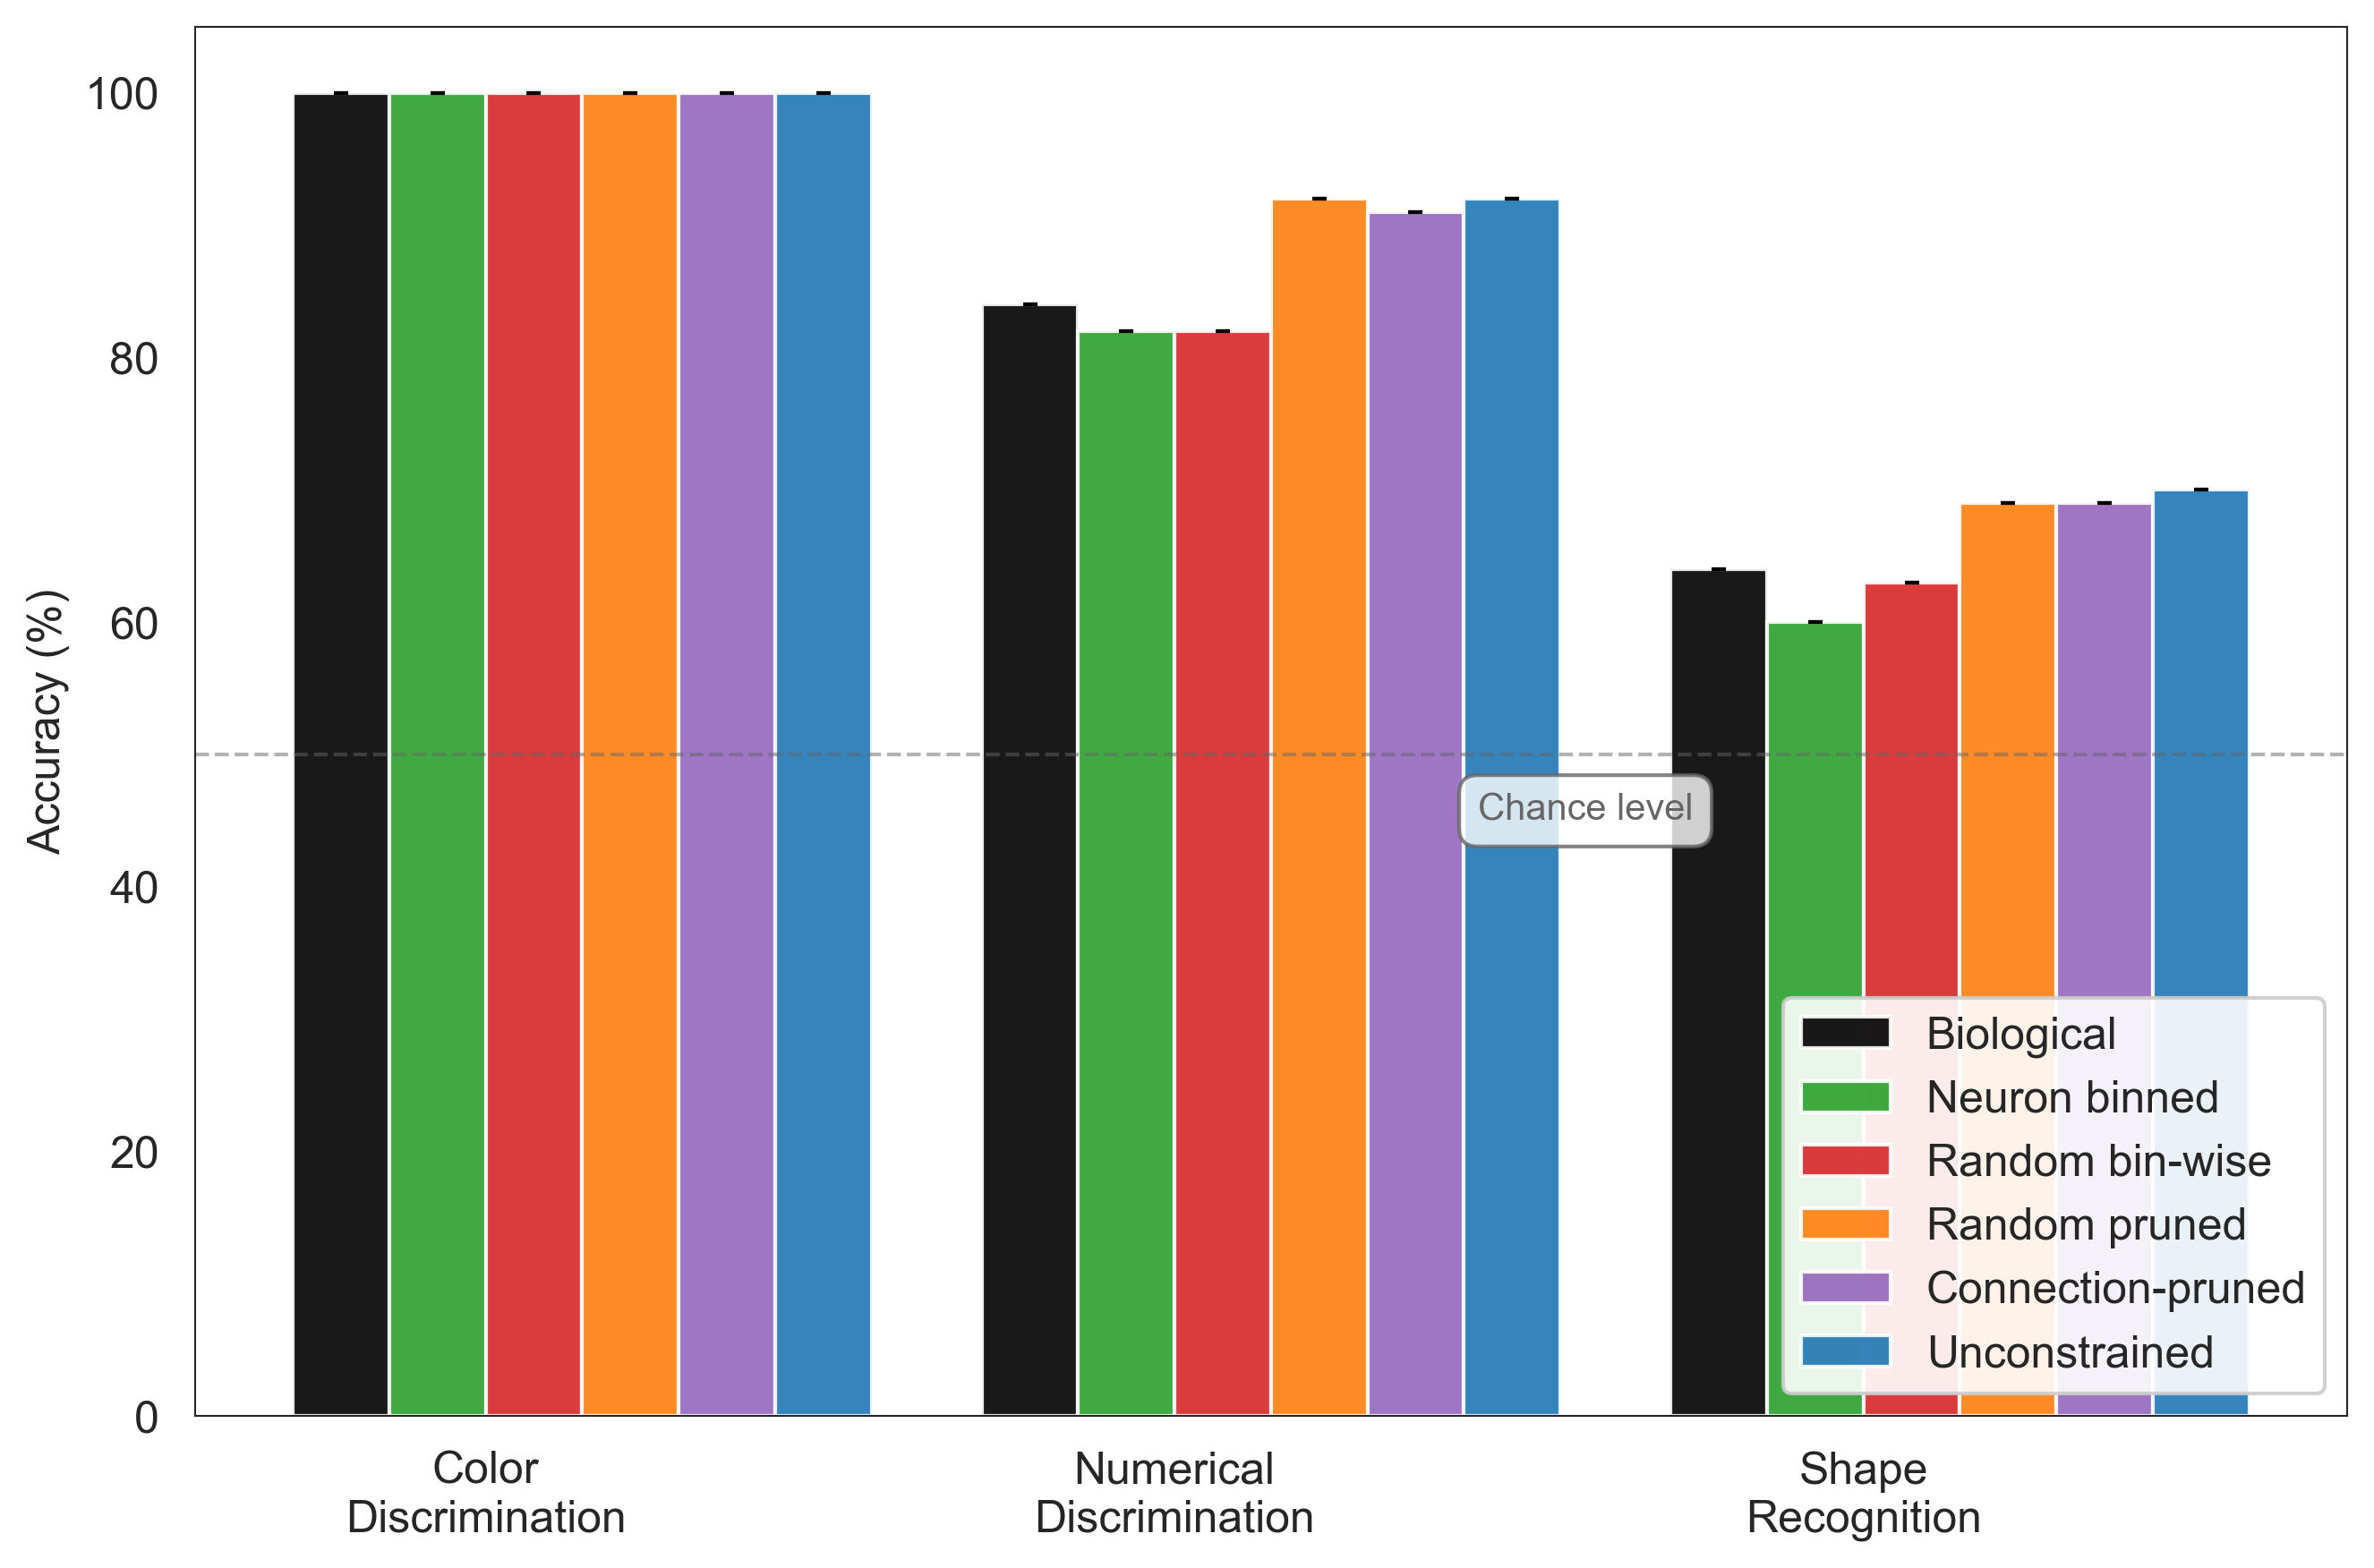

In [68]:
import importlib
from notebooks.visualization.random_networks_plots import models_accuracy
from notebooks.visualization.random_networks_plots import plot_config
importlib.reload(models_accuracy)
importlib.reload(plot_config)

from notebooks.visualization.random_networks_plots.models_accuracy import task_accuracy_comparison


figc = task_accuracy_comparison()

plt.savefig(os.path.join(plots_dir, "accuracy_comparison.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir, "accuracy_comparison.pdf"), bbox_inches="tight") 
plt.show()

# Panel d

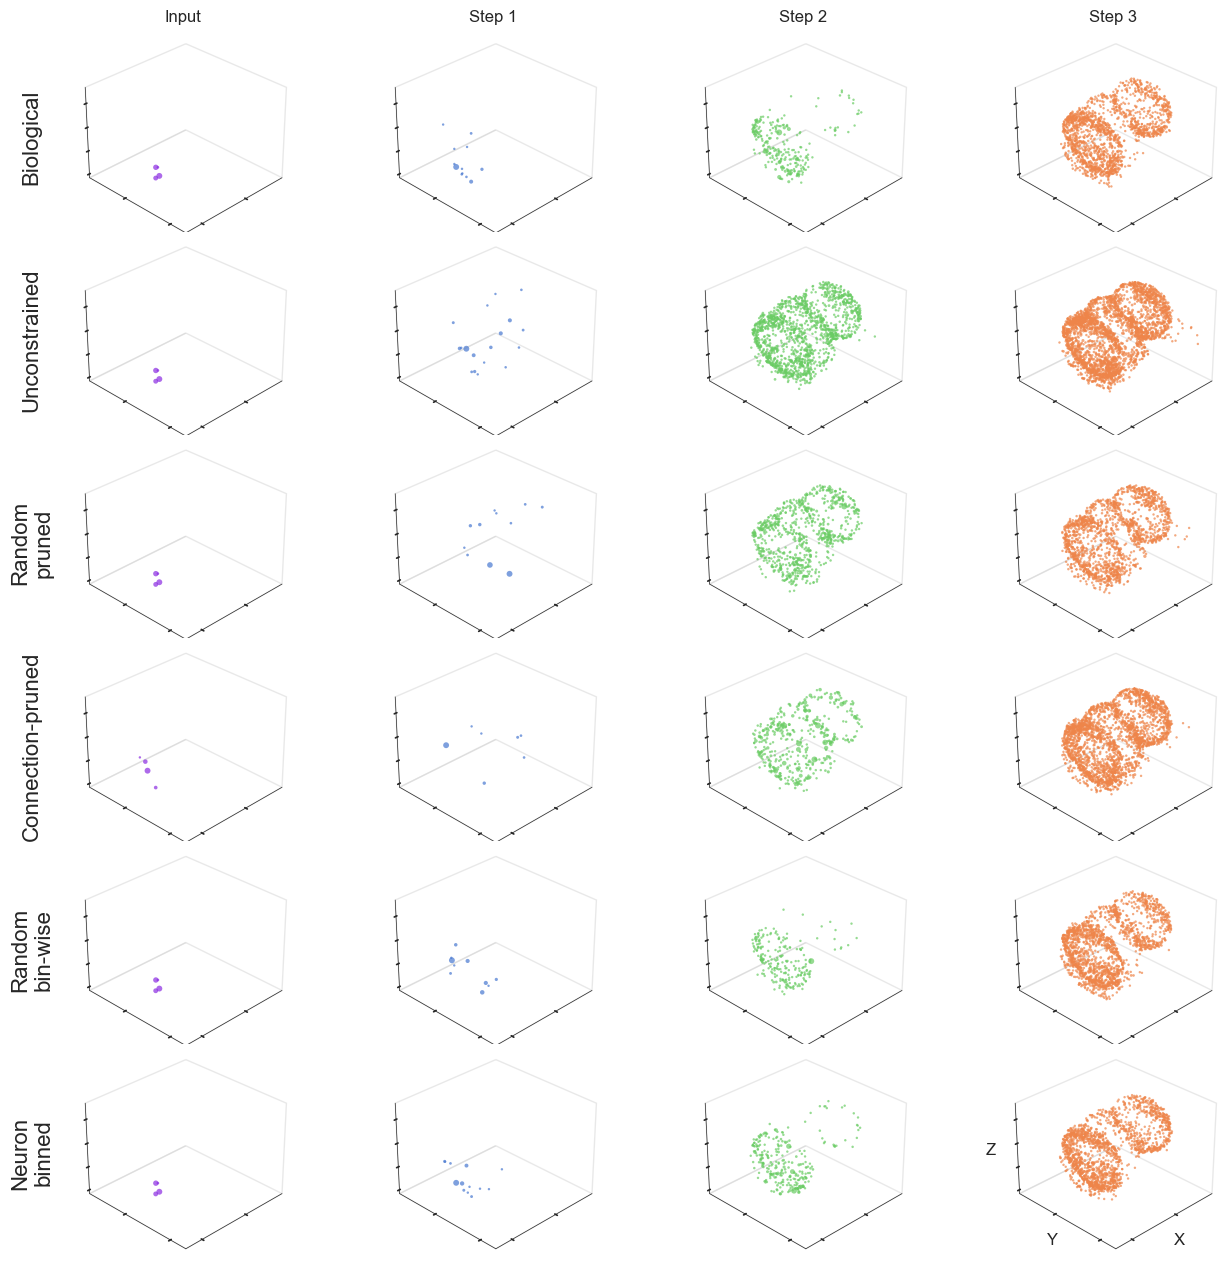

In [67]:
import importlib
from notebooks.visualization.random_networks_plots import activation_plots
importlib.reload(activation_plots)
from notebooks.visualization.random_networks_plots.activation_plots import visualize_steps_separated_compact

figd = visualize_steps_separated_compact(
    activations_dict,
    neuron_position_data,
    num_steps=3,
    max_neurons_percentage=2,
    padding_percent=5,
    figsize=(20, 16),
)

# Save figure with transparent background (Nature preference)
figd.savefig(os.path.join(plots_dir, "activation_evolution.png"), dpi=300, bbox_inches="tight", transparent=True)
figd.savefig(os.path.join(plots_dir, "activation_evolution.pdf"), bbox_inches="tight") 
plt.show()

{'Biological': [0.46461527413737386, 9.79857096693117, 62.065275932641555], 'Unconstrained': [0.6728663243689634, 51.406412696132996, 96.0310222254138], 'Random pruned': [0.4028580661376611, 28.460737495960647, 57.45431043768626], 'Connection-pruned': [0.275035007719651, 15.432120929230548, 86.505331944993], 'Random bin-wise': [0.37916053283544576, 8.489461778751211, 64.26052924491042], 'Neuron binned': [0.49118523571864564, 10.031237657534739, 62.21679652436178]}


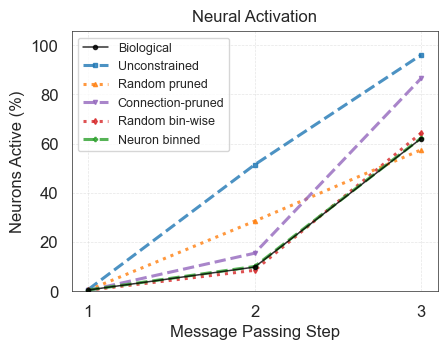

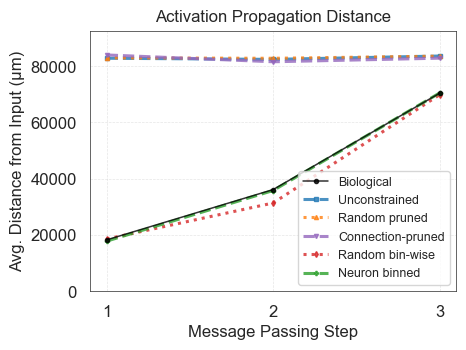

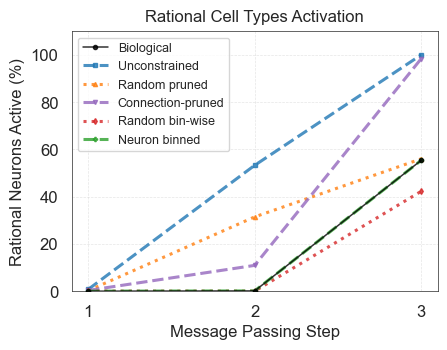

In [61]:
import importlib
from notebooks.visualization.random_networks_plots import activation_plots
importlib.reload(activation_plots)
from notebooks.visualization.random_networks_plots.activation_plots import plot_activation_statistics

fig5, fig6, fig7 = plot_activation_statistics(activations_dict, neuron_position_data, num_steps=3)
fig5.savefig(os.path.join(plots_dir, "neuron_activation.png"), dpi=300, bbox_inches="tight")
fig5.savefig(os.path.join(plots_dir, "neuron_activation.pdf"), bbox_inches="tight")
fig6.savefig(os.path.join(plots_dir, "propagation_distance.png"), dpi=300, bbox_inches="tight")
fig6.savefig(os.path.join(plots_dir, "propagation_distance.pdf"), bbox_inches="tight")
fig7.savefig(os.path.join(plots_dir, "thinking_neuron_activation.png"), dpi=300, bbox_inches="tight")
fig7.savefig(os.path.join(plots_dir, "thinking_neuron_activation.pdf"), bbox_inches="tight")
plt.show()

# All together

/tmp/ipykernel_29515/3261479241.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


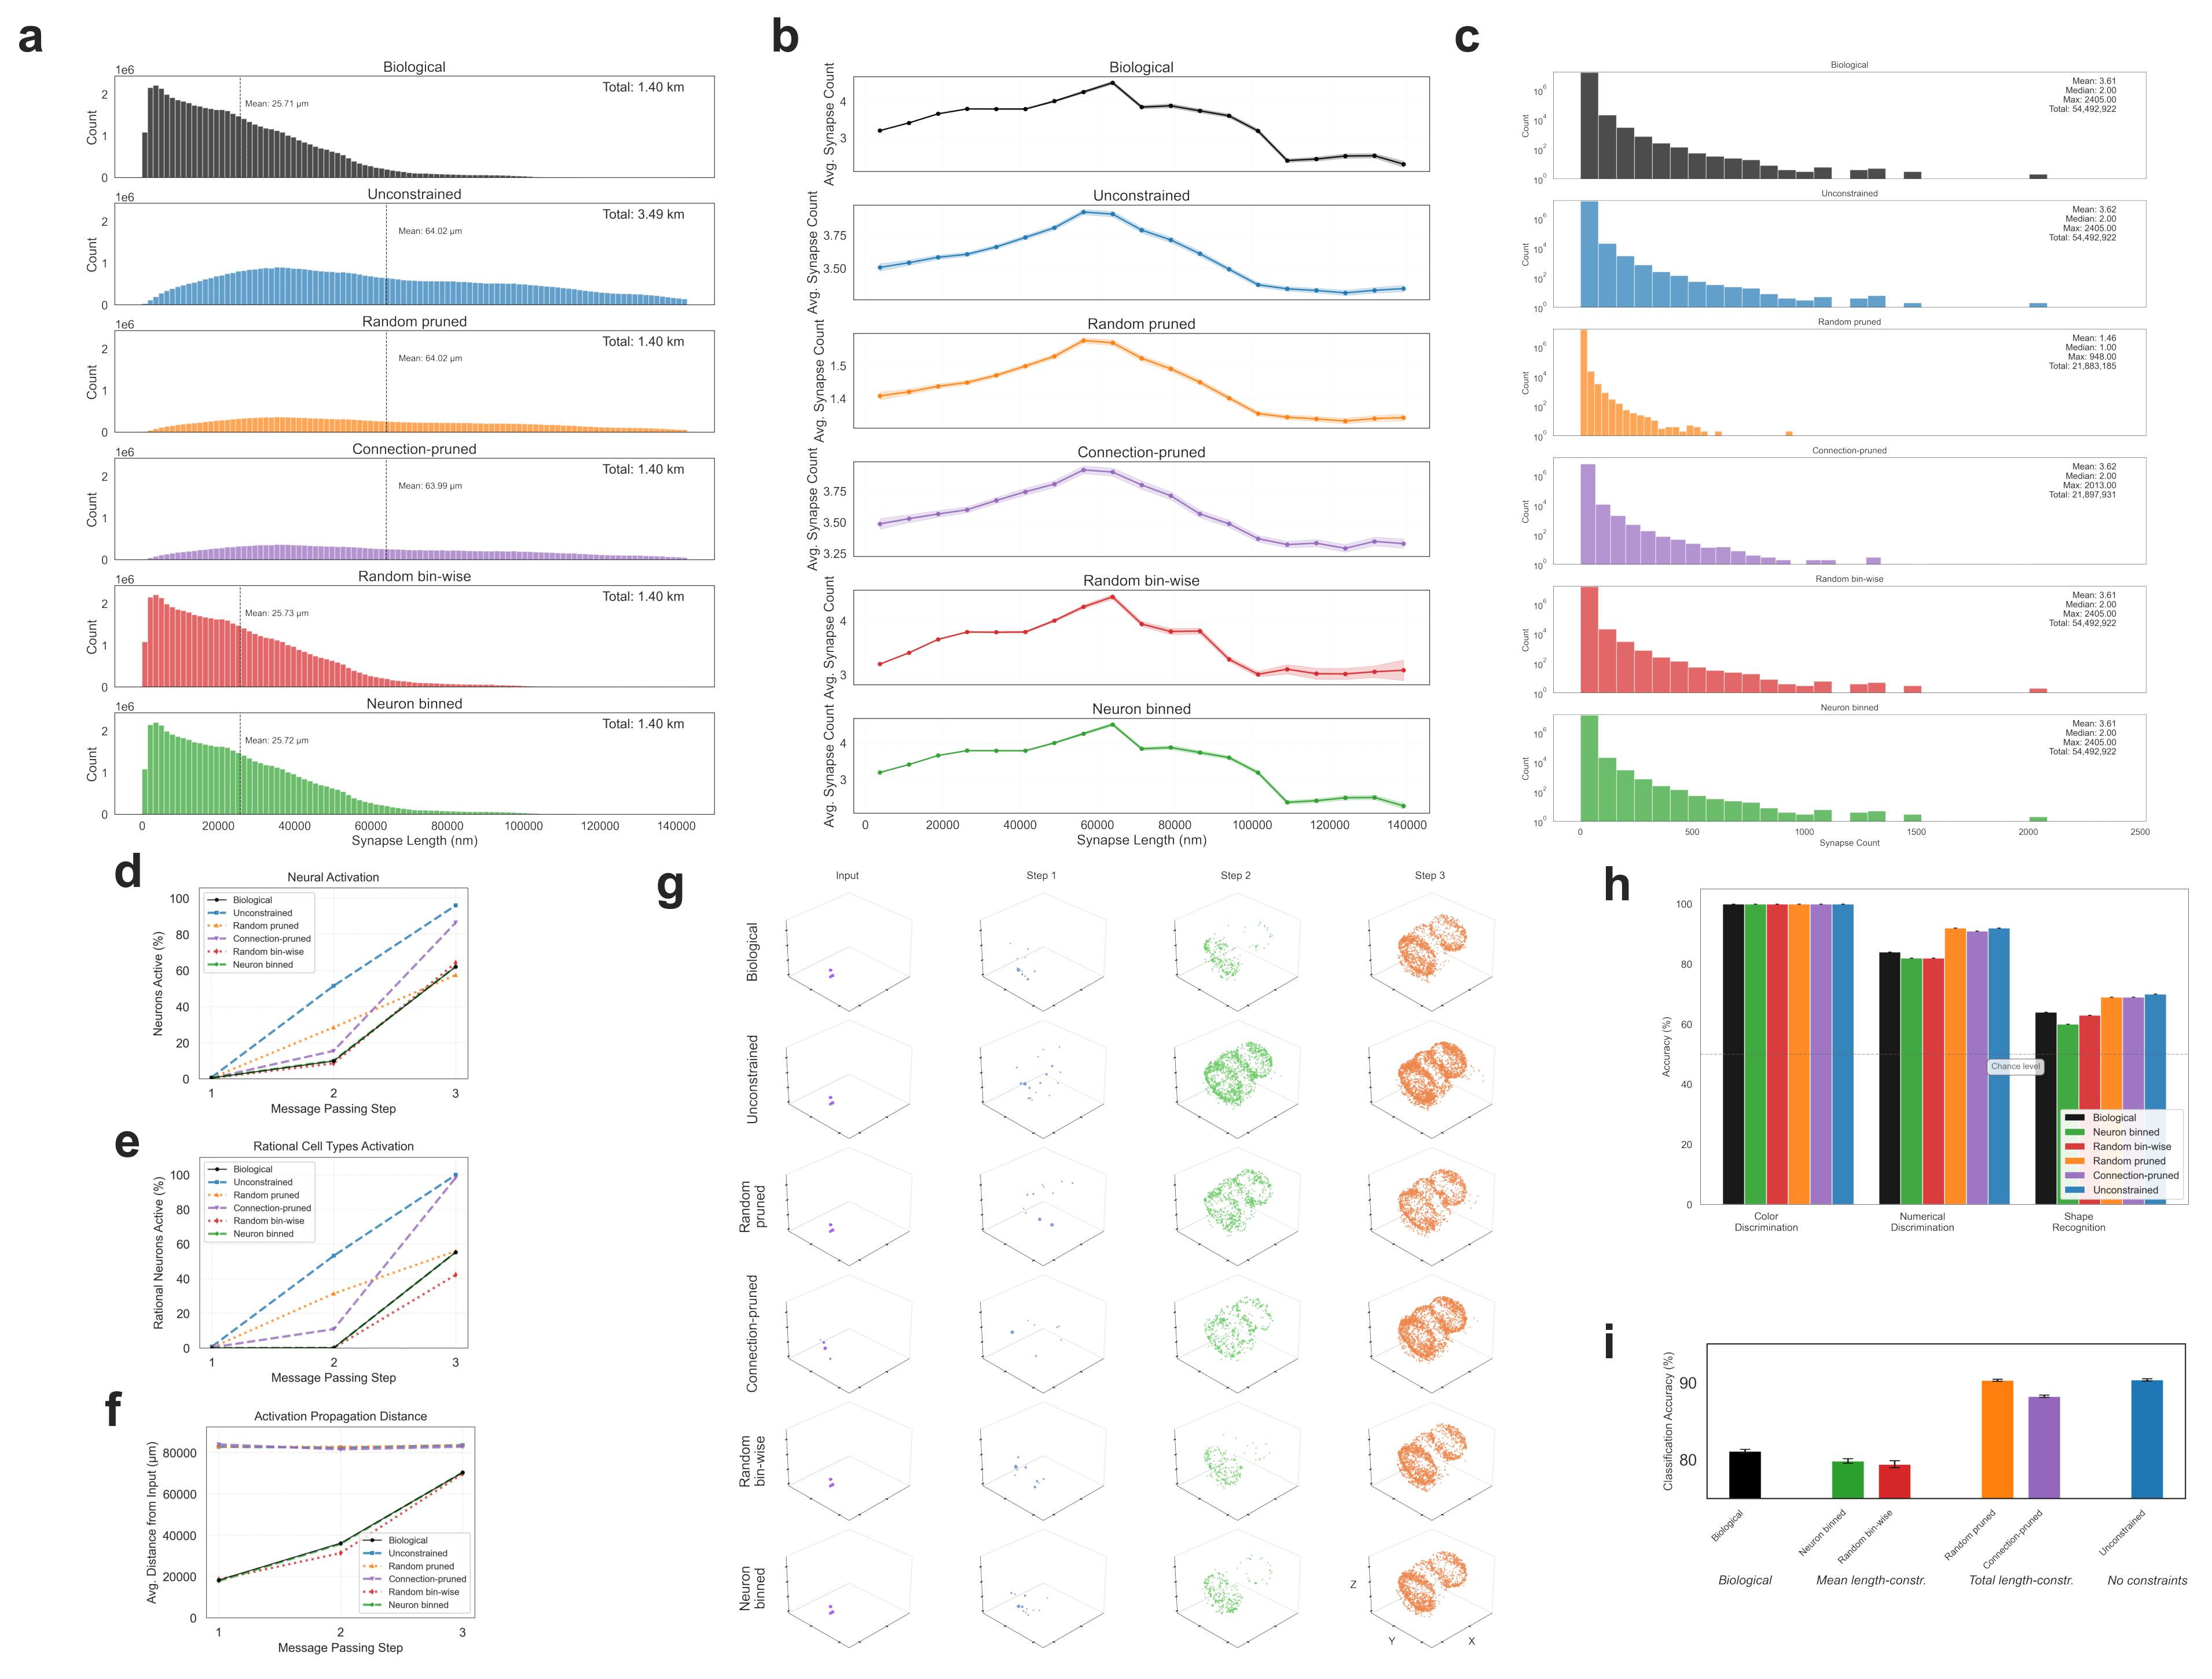

In [70]:
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

# Do this for each panel...

# Create the composite figure
fig = plt.figure(figsize=(16, 12), dpi=300)
gs = GridSpec(12, 12, figure=fig, wspace=0., hspace=0.1)

# Define subplot areas
## Upper row
ax1 = fig.add_subplot(gs[:6, :4])
ax2 = fig.add_subplot(gs[:6, 4:8])
ax3 = fig.add_subplot(gs[:6, 8:12])

# Lower block
## Left column
ax4 = fig.add_subplot(gs[6:8, 0:3])
ax5 = fig.add_subplot(gs[8:10, 0:3])
ax6 = fig.add_subplot(gs[10:12, 0:3])

# Big plot
ax7 = fig.add_subplot(gs[6:12, 3:9])

# Bottom-right column 
ax8 = fig.add_subplot(gs[6:9, 9:12])
ax9 = fig.add_subplot(gs[9:12, 9:12])


# Load the images
dir_path = os.path.join(PROJECT_ROOT, "plots")
ax1.imshow(mpimg.imread(os.path.join(dir_path, "synapse_length_distributions.png")))
ax2.imshow(mpimg.imread(os.path.join(dir_path, "synapse_count_per_length.png")))
ax3.imshow(mpimg.imread(os.path.join(dir_path, "synapse_counts_histogram.png")))

ax4.imshow(mpimg.imread(os.path.join(dir_path, "neuron_activation.png")))
ax5.imshow(mpimg.imread(os.path.join(dir_path, "thinking_neuron_activation.png")))
ax6.imshow(mpimg.imread(os.path.join(dir_path, "propagation_distance.png")))

ax7.imshow(mpimg.imread(os.path.join(dir_path, "activation_evolution.png")))
ax8.imshow(mpimg.imread(os.path.join(dir_path, "accuracy_comparison.png")))
ax9.imshow(mpimg.imread(os.path.join(dir_path, "efficiency_comparison.png")))

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.axis("off")

# Add panel labels with improved positioning
label_params = {"fontsize": 20, "fontweight": "bold", "va": "top", "ha": "left"}

ax1.text(-0.1, 1.05, "a", transform=ax1.transAxes, **label_params)
ax2.text(-0.05, 1.05, "b", transform=ax2.transAxes, **label_params)
ax3.text(-0.1, 1.05, "c", transform=ax3.transAxes, **label_params)
ax4.text(-0.1, 1.05, "d", transform=ax4.transAxes, **label_params)
ax5.text(-0.1, 1.05, "e", transform=ax5.transAxes, **label_params)
ax6.text(-0.1, 1.05, "f", transform=ax6.transAxes, **label_params)
ax7.text(-0.1, 1.0, "g", transform=ax7.transAxes, **label_params)
ax8.text(-0.1, 1.05, "h", transform=ax8.transAxes, **label_params)
ax9.text(-0.1, 1.05, "i", transform=ax9.transAxes, **label_params)

plt.tight_layout()

# save
plt.savefig(
    os.path.join(plots_dir, "figure2_panel.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(plots_dir, "figure2_panel.pdf"), bbox_inches="tight"
)

plt.show()